In [1]:
# Data manipulation and processing
import pandas as pd
import numpy as np

# Geospatial data processing
import geopandas as gpd
from shapely.geometry import LineString, Point

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FixedLocator
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# System operations
import os

In [2]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

In [3]:
root = r'PATH_TO_YOUR_DATA'

In [4]:
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'figure.dpi': 200,
    'font.size': 10
})

In [5]:
city_grid = gpd.read_file(os.path.join(root, 'data', 'shp', 'ss_city_grid.shp'))
sixth = gpd.read_file(os.path.join(root, 'data', 'shp', 'SixthRing_Polygon.shp'))
sixth_fnid = city_grid.sjoin(sixth, how='inner', predicate='intersects')['fnid'].unique()

grid_point = city_grid.loc[:,['fnid', 'geometry']].copy()
grid_point['geometry'] = grid_point.to_crs(32650).geometry.centroid
grid_point['lon'] = grid_point.geometry.x.astype('int32')
grid_point['lat'] = grid_point.geometry.y.astype('int32')
grid_point_six_c = grid_point.loc[grid_point['fnid'].isin(sixth_fnid)]
beijing_center = gpd.read_file(os.path.join(root, 'data', 'shp', 'Beijing_center.shp'))
beijing_center_32650 = beijing_center.to_crs(32650).geometry.iloc[0]

def calculate_distance(row):
    point = row.geometry
    return point.distance(beijing_center_32650)

grid_point_six_c['distance_c'] = grid_point_six_c.apply(calculate_distance, axis=1).astype(int)

D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
house_price_pop = pd.read_csv(os.path.join(root, 'data', 'house_price_pop.csv'))
pcount1903_attr = pd.read_csv(os.path.join(root, 'data', 'pcount1903_attr.csv'))
pcount2403_attr = pd.read_csv(os.path.join(root, 'data', 'pcount2403_attr.csv'))
home_poi_num2019 = pd.read_csv(os.path.join(root, 'data', 'home_poi_num2019.csv'))
home_poi_num2024 = pd.read_csv(os.path.join(root, 'data', 'home_poi_num2024.csv'))

In [7]:
home_contact_data1903 = pd.read_csv(os.path.join(root, 'data', 'home_contact_data1903_500k.csv'))

def od_distance(od_data):
    od_grid = od_data.loc[:, ['home_a','home_b']].drop_duplicates()
    od_grid_h = od_grid.merge(grid_point.loc[:,['fnid','lon','lat']].rename(columns={'fnid':'home_a','lon':'hlon','lat':'hlat'}))
    od_grid_hv = od_grid_h.merge(grid_point.loc[:,['fnid','lon','lat']].rename(columns={'fnid':'home_b','lon':'vlon','lat':'vlat'}))
    geometry = [LineString(xy_list) for xy_list in zip(zip(od_grid_hv.hlon, od_grid_hv.hlat), zip(od_grid_hv.vlon, od_grid_hv.vlat))]
    od_grid_hv_geo = gpd.GeoDataFrame(od_grid_hv, crs="EPSG:32650", geometry=geometry)
    od_grid_hv_geo['distance'] = round(od_grid_hv_geo.length, 0).astype('int')
    return od_grid_hv_geo.loc[:,['home_a','home_b','distance']]
home_contact_data1903_dis = od_distance(home_contact_data1903)
home_poi_num2019['poi_num'] = home_poi_num2019.iloc[:,1:-1].sum(axis=1)
home_contact_stat1903 = home_contact_data1903.merge(home_contact_data1903_dis).merge(house_price_pop.loc[:,['home_grid','ses']].rename(columns={'home_grid':'home_a','ses':'ses_a'})).merge(house_price_pop.loc[:,['home_grid','ses']].rename(columns={'home_grid':'home_b','ses':'ses_b'}))
home_contact_stat1903 = home_contact_stat1903.merge(pcount1903_attr.rename(columns={'home_grid':'home_a','young_ratio':'young_ratio_a','old_ratio':'old_ratio_a','male_ratio':'male_ratio_a','local_ratio':'local_ratio_a'}), on='home_a').merge(pcount1903_attr.rename(columns={'home_grid':'home_b','young_ratio':'young_ratio_b','old_ratio':'old_ratio_b','male_ratio':'male_ratio_b','local_ratio':'local_ratio_b'})) 
home_contact_stat1903 = home_contact_stat1903.merge(home_poi_num2019.loc[:,['fnid','poi_num']].rename(columns={'fnid':'home_a','poi_num':'poi_num_a'})).merge(home_poi_num2019.loc[:,['fnid','poi_num']].rename(columns={'fnid':'home_b','poi_num':'poi_num_b'}))

from sklearn.metrics.pairwise import cosine_similarity
social_a = home_contact_stat1903.loc[:,['young_ratio_a','old_ratio_a','male_ratio_a','local_ratio_a']]
social_b = home_contact_stat1903.loc[:,['young_ratio_b','old_ratio_b','male_ratio_b','local_ratio_b']]

social_similarities = []
for i in tqdm(range(len(social_a))):
    vec_a = social_a.iloc[i].values.reshape(1, -1)
    vec_b = social_b.iloc[i].values.reshape(1, -1)
    similarity = cosine_similarity(vec_a, vec_b)[0][0]
    social_similarities.append(similarity)
home_contact_stat1903['social_similarity'] = social_similarities

# home_contact_stat1903['social_similarity'] = np.diag(cosine_similarity(social_a, social_b))
home_contact_stat1903['ses_diff'] = (home_contact_stat1903['ses_a'] - home_contact_stat1903['ses_b']).abs()
home_contact_stat1903['poi_num_diff'] = (home_contact_stat1903['poi_num_a'] - home_contact_stat1903['poi_num_b']).abs()
home_contact_stat1903.loc[:,['concat_prob','distance','social_similarity','ses_diff','poi_num_a']]
# home_contact_stat1903.to_csv(os.path.join(root, 'data', 'home_contact_stat1903.csv'), index=False)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [04:28<00:00, 1861.20it/s]


,concat_prob,distance,social_similarity,ses_diff,poi_num_a
0,26.049595,2015,0.999006,28,55
1,4.440193,15061,0.998687,16,50
2,12.516988,20599,0.998401,33,73
3,9.284452,25690,0.997295,22,28
4,12.528627,10505,0.994194,37,63
...,...,...,...,...,...
499995,12.062138,15260,0.976577,45,34
499996,8.377285,14727,0.976721,11,93
499997,10.105274,9261,0.986638,59,25
499998,6.171440,23339,0.992328,22,9


In [8]:
home_contact_data2403 =pd.read_csv(os.path.join(root, 'data', 'home_contact_data2403_500k.csv'))

def od_distance(od_data):
    od_grid = od_data.loc[:, ['home_a','home_b']].drop_duplicates()
    od_grid_h = od_grid.merge(grid_point.loc[:,['fnid','lon','lat']].rename(columns={'fnid':'home_a','lon':'hlon','lat':'hlat'}))
    od_grid_hv = od_grid_h.merge(grid_point.loc[:,['fnid','lon','lat']].rename(columns={'fnid':'home_b','lon':'vlon','lat':'vlat'}))
    geometry = [LineString(xy_list) for xy_list in zip(zip(od_grid_hv.hlon, od_grid_hv.hlat), zip(od_grid_hv.vlon, od_grid_hv.vlat))]
    od_grid_hv_geo = gpd.GeoDataFrame(od_grid_hv, crs="EPSG:32650", geometry=geometry)
    od_grid_hv_geo['distance'] = round(od_grid_hv_geo.length, 0).astype('int')
    return od_grid_hv_geo.loc[:,['home_a','home_b','distance']]

home_contact_data2403_dis = od_distance(home_contact_data2403)
home_poi_num2024['poi_num'] = home_poi_num2024.iloc[:,1:-1].sum(axis=1)
home_contact_stat2403 = home_contact_data2403.merge(home_contact_data2403_dis).merge(house_price_pop.loc[:,['home_grid','ses']].rename(columns={'home_grid':'home_a','ses':'ses_a'})).merge(house_price_pop.loc[:,['home_grid','ses']].rename(columns={'home_grid':'home_b','ses':'ses_b'}))
home_contact_stat2403 = home_contact_stat2403.merge(pcount2403_attr.rename(columns={'home_grid':'home_a','young_ratio':'young_ratio_a','old_ratio':'old_ratio_a','male_ratio':'male_ratio_a','local_ratio':'local_ratio_a'}), on='home_a').merge(pcount2403_attr.rename(columns={'home_grid':'home_b','young_ratio':'young_ratio_b','old_ratio':'old_ratio_b','male_ratio':'male_ratio_b','local_ratio':'local_ratio_b'})) 
home_contact_stat2403 = home_contact_stat2403.merge(home_poi_num2024.loc[:,['fnid','poi_num']].rename(columns={'fnid':'home_a','poi_num':'poi_num_a'})).merge(home_poi_num2024.loc[:,['fnid','poi_num']].rename(columns={'fnid':'home_b','poi_num':'poi_num_b'}))

from sklearn.metrics.pairwise import cosine_similarity
social_a = home_contact_stat2403.loc[:,['young_ratio_a','old_ratio_a','male_ratio_a','local_ratio_a']]
social_b = home_contact_stat2403.loc[:,['young_ratio_b','old_ratio_b','male_ratio_b','local_ratio_b']]

social_similarities = []
for i in tqdm(range(len(social_a))):
    vec_a = social_a.iloc[i].values.reshape(1, -1)
    vec_b = social_b.iloc[i].values.reshape(1, -1)
    similarity = cosine_similarity(vec_a, vec_b)[0][0]
    social_similarities.append(similarity)
home_contact_stat2403['social_similarity'] = social_similarities

# home_contact_stat2403['social_similarity'] = np.diag(cosine_similarity(social_a, social_b))
home_contact_stat2403['ses_diff'] = (home_contact_stat2403['ses_a'] - home_contact_stat2403['ses_b']).abs()
home_contact_stat2403['poi_num_diff'] = (home_contact_stat2403['poi_num_a'] - home_contact_stat2403['poi_num_b']).abs()
home_contact_stat2403.loc[:,['concat_prob','distance','social_similarity','ses_diff']]
# home_contact_stat2403.to_csv(os.path.join(root, 'data', 'home_contact_stat2403.csv'), index=False)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [04:36<00:00, 1806.32it/s]


,concat_prob,distance,social_similarity,ses_diff
0,5.669206,32206,0.993622,42
1,13.744684,5904,0.983449,41
2,5.311254,16738,0.992497,59
3,18.086449,13210,0.980194,70
4,2.445620,32823,0.986178,26
...,...,...,...,...
499995,20.314249,5262,0.998766,8
499996,10.550567,15423,0.994853,77
499997,2.348433,36855,0.987636,7
499998,6.165997,25318,0.990086,74


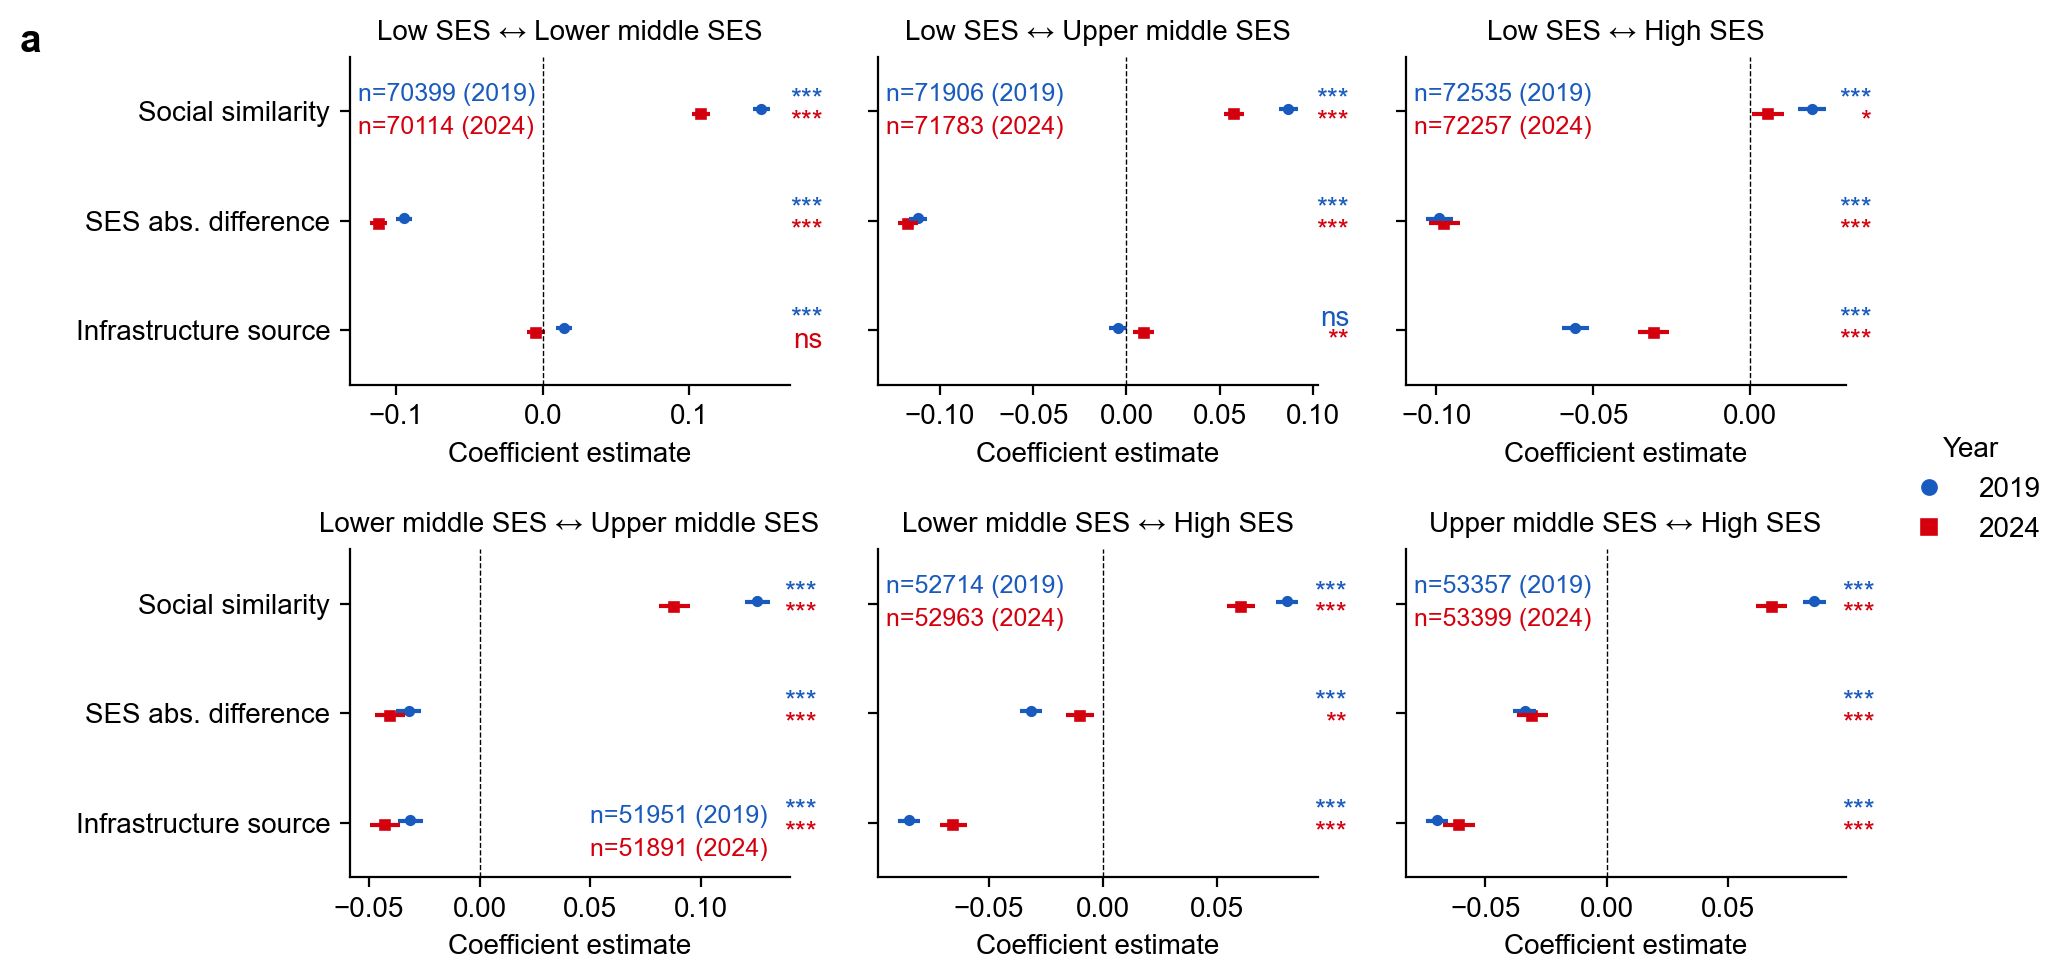

In [9]:
COLORS = ['#185abd', '#d5000e']

def process_data_pair(data, group_a, group_b, columns):
    mask = ((data['ses_a'].isin(group_a) & data['ses_b'].isin(group_b)) | 
            (data['ses_a'].isin(group_b) & data['ses_b'].isin(group_a)))
    data = data.loc[data['concat_prob']>0]
    data = data.loc[mask].reset_index(drop=True)
    data['log_concat_prob'] = np.log(data['concat_prob'] + 1)
    data['ses_diff_abs'] = data['ses_diff'].abs()
    X = data[columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=columns)
    X_scaled = sm.add_constant(X_scaled)
    y = data['log_concat_prob']
    model_ols = sm.OLS(y, X_scaled)
    result_ols = model_ols.fit()
    coefficients = result_ols.params
    standard_errors = result_ols.bse
    pvalues = result_ols.pvalues
    conf_intervals = result_ols.conf_int(alpha=0.05)
    return coefficients, standard_errors, pvalues, conf_intervals

def plot_data(coefficients_df, y_tick_labels, ax):
    color_palette = {year: color for year, color in zip(coefficients_df['Year'].unique(), COLORS)}
    ax = sns.pointplot(
        y='Coefficient', 
        x='Value', 
        hue='Year',
        markersize=2,
        data=coefficients_df,
        errorbar=("ci", 100),
        capsize=.4,
        markers=["o", "s"],
        dodge=True,
        linestyle='none',
        palette=color_palette,
        ax=ax
    )
    ax.yaxis.set_major_locator(FixedLocator(range(len(y_tick_labels))))
    ax.set_yticklabels(y_tick_labels)
    x_min, x_max = ax.get_xlim()
    x_range = x_max - x_min
    right_margin = x_max + 0.1 * x_range
    
    # Store the current ylim to restore later
    original_ylim = ax.get_ylim()
    
    for i, row in coefficients_df.iterrows():
        coefficient = row['Coefficient']
        try:
            if coefficient == 'social_similarity':
                y_pos = y_tick_labels.index('Social similarity')
            elif coefficient == 'ses_diff_abs':
                y_pos = y_tick_labels.index('SES abs. difference')
            elif coefficient == 'poi_num_diff':
                y_pos = y_tick_labels.index('Infrastructure source')
            else:
                continue
        except ValueError:
            continue
            
        offset = 0.1 if row['Year'] == '2024' else -0.1
        
        # Add horizontal line for confidence interval
        ax.hlines(y=y_pos + (0.02 if row['Year'] == '2024' else -0.02), 
                 xmin=row['CI_Lower'], 
                 xmax=row['CI_Upper'],
                 color=color_palette[row['Year']],
                 linewidth=1.5,
                 alpha=1)
        
        if row['PValue'] < 0.001:
            sig_label = '***'
        elif row['PValue'] < 0.01:
            sig_label = '**'
        elif row['PValue'] < 0.05:
            sig_label = '*'
        else:
            sig_label = 'ns'
        ax.text(right_margin, y_pos + offset, sig_label, 
                ha='right', va='center', 
                color=color_palette[row['Year']])

    # Restore original ylim to maintain plot appearance
    ax.set_ylim(original_ylim)
    
    ax.set_xlabel('Coefficient estimate')
    ax.set_ylabel('')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)
    return ax

def process_and_plot_pair(data_1903, data_2403, group_a, group_b, columns, y_tick_labels, ax):
    coefficients_1903, standard_errors_1903, pvalues_1903, conf_intervals_1903 = process_data_pair(data_1903, group_a, group_b, columns)
    coefficients_2403, standard_errors_2403, pvalues_2403, conf_intervals_2403 = process_data_pair(data_2403, group_a, group_b, columns)

    coefficients_df = pd.concat([
        pd.DataFrame({
            'Coefficient': coefficients_1903.index[1:],
            'Value': coefficients_1903.values[1:],
            'PValue': pvalues_1903.values[1:],
            'SE': standard_errors_1903.values[1:],
            'Year': '2019',
            'CI_Lower': conf_intervals_1903.values[1:, 0],
            'CI_Upper': conf_intervals_1903.values[1:, 1]
        }),
        pd.DataFrame({
            'Coefficient': coefficients_2403.index[1:],
            'Value': coefficients_2403.values[1:],
            'PValue': pvalues_2403.values[1:],
            'SE': standard_errors_2403.values[1:],
            'Year': '2024',
            'CI_Lower': conf_intervals_2403.values[1:, 0],
            'CI_Upper': conf_intervals_2403.values[1:, 1]
        })
    ])
    return plot_data(coefficients_df, y_tick_labels, ax)


groups = [
    np.arange(1, 26),    # Low SES (p1-p25)
    np.arange(26, 51),   # Lower middle SES (p26-p50)
    np.arange(51, 76),   # Upper middle SES (p51-p75)
    np.arange(76, 101)   # High SES (p76-p100)
]
group_labels = ['Low', 'Lower middle', 'Upper middle', 'High']

columns = ['social_similarity','ses_diff_abs','poi_num_diff']
y_tick_labels = ['Social similarity', 'SES abs. difference', 'Infrastructure source']
combinations = [(i, j) for i in range(4) for j in range(i, 4) if i != j]
n_plots = len(combinations)
n_rows = (n_plots + 1) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(10, 2.5 * n_rows), sharey=True)
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (i, j) in enumerate(combinations):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    group_a = groups[i]
    group_b = groups[j]

    # Calculate sample sizes for both years
    mask_1903 = ((home_contact_stat1903['ses_a'].isin(group_a) & home_contact_stat1903['ses_b'].isin(group_b)) | 
                (home_contact_stat1903['ses_a'].isin(group_b) & home_contact_stat1903['ses_b'].isin(group_a)))
    n_1903 = len(home_contact_stat1903.loc[mask_1903 & (home_contact_stat1903['concat_prob'] > 0)])
    
    mask_2403 = ((home_contact_stat2403['ses_a'].isin(group_a) & home_contact_stat2403['ses_b'].isin(group_b)) | 
                (home_contact_stat2403['ses_a'].isin(group_b) & home_contact_stat2403['ses_b'].isin(group_a)))
    n_2403 = len(home_contact_stat2403.loc[mask_2403 & (home_contact_stat2403['concat_prob'] > 0)])
    
    process_and_plot_pair(home_contact_stat1903, home_contact_stat2403, group_a, group_b, columns, y_tick_labels, ax)
    
    if row == 1 and col == 0:
        ax.text(0.95, 0.15, f"n={n_1903:} (2019)", 
                transform=ax.transAxes,
                ha='right', va='bottom',
                fontsize=9,
                color=COLORS[0],  # Blue for 2019
                linespacing=1.5)
        ax.text(0.95, 0.05, f"\nn={n_2403:} (2024)", 
                transform=ax.transAxes,
                ha='right', va='bottom',
                fontsize=9,
                color=COLORS[1],  # Red for 2024
                linespacing=1.5)
    else:
        # Default position for other subplots
        ax.text(0.22, 0.85, f"n={n_1903:} (2019)", 
                transform=ax.transAxes,
                ha='center', va='bottom',
                fontsize=9,
                color=COLORS[0],  # Blue for 2019
                linespacing=1.5)
        ax.text(0.22, 0.75, f"\nn={n_2403:} (2024)", 
                transform=ax.transAxes,
                ha='center', va='bottom',
                fontsize=9,
                color=COLORS[1],  # Red for 2024
                linespacing=1.5)
    
    ax.set_title(f'{group_labels[i]} SES ↔ {group_labels[j]} SES', fontsize=10)

for idx in range(n_plots, n_rows * 2):
    row = idx // 2
    col = idx % 2
    fig.delaxes(axes[row, col])

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           markerscale=2,
           loc='center right',
           bbox_to_anchor=(1.01, 0.5),
           ncol=1,
           title='Year',
           frameon=False)

for ax_row in axes:
    for ax in ax_row:
        if isinstance(ax, plt.Axes):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

plt.tight_layout()
plt.subplots_adjust(right=0.9, wspace=0.2, hspace=0.5)
axes[0,0].text(-0.7, 1.1, 'a', transform=axes[0,0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# plt.savefig('fig3a.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [10]:
def process_data_pair(data, group_a, group_b, columns):
    mask = ((data['ses_a'].isin(group_a) & data['ses_b'].isin(group_b)) | 
            (data['ses_a'].isin(group_b) & data['ses_b'].isin(group_a)))
    data = data.loc[data['concat_prob']>0]
    data = data.loc[mask].reset_index(drop=True)
    data['log_concat_prob'] = np.log(data['concat_prob'] + 1)
    data['ses_diff_abs'] = data['ses_diff'].abs()
    X = data[columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=columns)
    X_scaled = sm.add_constant(X_scaled)
    y = data['log_concat_prob']
    model_ols = sm.OLS(y, X_scaled)
    result_ols = model_ols.fit()
    # Get all the statistics we need
    coefficients = result_ols.params
    standard_errors = result_ols.bse
    pvalues = result_ols.pvalues
    conf_intervals = result_ols.conf_int(alpha=0.05)
    r_squared = result_ols.rsquared
    # Create a summary DataFrame
    results_df = pd.DataFrame({
        'Variable': coefficients.index,
        'Coefficient': coefficients.values,
        'Std_Error': standard_errors.values,
        'P_Value': pvalues.values,
        'CI_Lower': conf_intervals.values[:, 0],
        'CI_Upper': conf_intervals.values[:, 1],
        'R_Squared': r_squared
    })
    return results_df, len(data)

def print_regression_results(results_df, year, group_a_label, group_b_label, n):
    print(f"\n{year} Results - {group_a_label} SES ↔ {group_b_label} SES (n={n})")
    print(f"R² = {results_df['R_Squared'].iloc[0]:.3f}")
    print("\nCoefficients:")
    # Skip the intercept (first row)
    for _, row in results_df.iloc[1:].iterrows():
        # Format p-value string
        if row['P_Value'] < 0.001:
            p_str = "< 0.001"
        elif row['P_Value'] < 0.01:
            p_str = f"= {row['P_Value']:.3f}"
        elif row['P_Value'] < 0.05:
            p_str = f"= {row['P_Value']:.3f}"
        else:
            p_str = f"= {row['P_Value']:.3f}"
        print(f"{row['Variable']}: β = {row['Coefficient']:.3f} "
              f"(95% CI: {row['CI_Lower']:.3f}-{row['CI_Upper']:.3f}), "
              f"p {p_str}")

# Main analysis
groups = [
    np.arange(1, 26),    # Low SES (p1-p25)
    np.arange(26, 51),   # Lower middle SES (p26-p50)
    np.arange(51, 76),   # Upper middle SES (p51-p75)
    np.arange(76, 101)   # High SES (p76-p100)
]
group_labels = ['Low', 'Lower middle', 'Upper middle', 'High']

columns = ['social_similarity','ses_diff_abs','poi_num_diff']

combinations = [(i, j) for i in range(4) for j in range(i, 4) if i != j]

for i, j in combinations:
    group_a = groups[i]
    group_b = groups[j]
    group_a_label = group_labels[i]
    group_b_label = group_labels[j]
    
    # Process 2019 data
    results_1903, n_1903 = process_data_pair(home_contact_stat1903, group_a, group_b, columns)
    print_regression_results(results_1903, "2019", group_a_label, group_b_label, n_1903)
    
    # Process 2024 data
    results_2403, n_2403 = process_data_pair(home_contact_stat2403, group_a, group_b, columns)
    print_regression_results(results_2403, "2024", group_a_label, group_b_label, n_2403)
    
    print("\n" + "="*80 + "\n")


2019 Results - Low SES ↔ Lower middle SES (n=70399)
R² = 0.055

Coefficients:
social_similarity: β = 0.149 (95% CI: 0.144-0.155), p < 0.001
ses_diff_abs: β = -0.095 (95% CI: -0.100--0.089), p < 0.001
poi_num_diff: β = 0.014 (95% CI: 0.009-0.020), p < 0.001

2024 Results - Low SES ↔ Lower middle SES (n=70114)
R² = 0.036

Coefficients:
social_similarity: β = 0.108 (95% CI: 0.102-0.114), p < 0.001
ses_diff_abs: β = -0.112 (95% CI: -0.118--0.106), p < 0.001
poi_num_diff: β = -0.005 (95% CI: -0.011-0.002), p = 0.145



2019 Results - Low SES ↔ Upper middle SES (n=71906)
R² = 0.045

Coefficients:
social_similarity: β = 0.087 (95% CI: 0.082-0.092), p < 0.001
ses_diff_abs: β = -0.112 (95% CI: -0.117--0.107), p < 0.001
poi_num_diff: β = -0.005 (95% CI: -0.010-0.000), p = 0.070

2024 Results - Low SES ↔ Upper middle SES (n=71783)
R² = 0.030

Coefficients:
social_similarity: β = 0.058 (95% CI: 0.052-0.063), p < 0.001
ses_diff_abs: β = -0.117 (95% CI: -0.123--0.112), p < 0.001
poi_num_diff: β = 0

In [11]:
def process_pairwise_data(data, group1, group2, columns):
    # Combine both groups and filter data
    combined_group = np.concatenate([group1, group2])
    data = data.loc[data['ses_a'].isin(combined_group)].reset_index(drop=True)
    
    # Create interaction pairs (both directions)
    data['ses_diff_abs'] = data['ses_diff'].abs()
    
    X = data[columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=columns)
    X_scaled = sm.add_constant(X_scaled)
    y = data['concat_prob']
    
    model_ols = sm.OLS(y, X_scaled)
    result_ols = model_ols.fit()
    
    coefficients = result_ols.params
    standard_errors = result_ols.bse
    pvalues = result_ols.pvalues
    conf_intervals = result_ols.conf_int()
    
    return coefficients, standard_errors, pvalues, conf_intervals

def plot_pairwise_data(coefficients_df, y_tick_labels, ax, title):
    COLORS = ['#d3e3fd', '#f6b2b0']
    color_palette = {year: color for year, color in zip(coefficients_df['Year'].unique(), COLORS)}
    
    ax = sns.pointplot(
        y='Coefficient', 
        x='Value', 
        hue='Year',
        data=coefficients_df,
        errorbar=("ci", 100),
        capsize=.4,
        markers=["o", "s"],
        alpha=1,
        dodge=True,
        linestyle='none',
        palette=color_palette,
        ax=ax
    )
    
    ax.yaxis.set_major_locator(FixedLocator(range(len(y_tick_labels))))
    ax.set_yticklabels(y_tick_labels)
    
    for i, row in coefficients_df.iterrows():
        coefficient = row['Coefficient']
        p_value = row['PValue']
        try:
            if coefficient == 'distance':
                y_pos = y_tick_labels.index('Residents distance')
            elif coefficient == 'social_similarity':
                y_pos = y_tick_labels.index('Social similarity')
            elif coefficient == 'ses_diff_abs':
                y_pos = y_tick_labels.index('SES abs. difference')
            elif coefficient == 'poi_num_diff':
                y_pos = y_tick_labels.index('Infrastructure source')
            else:
                continue
        except ValueError:
            continue
        
        offset = 0.05 if row['Year'] == '2024' else -0.30
        if p_value < 0.001:
            sig_label = '***'
        elif p_value < 0.01:
            sig_label = '**'
        elif p_value < 0.05:
            sig_label = '*'
        else:
            sig_label = 'ns'
        
        ax.text(5, y_pos + offset, sig_label, ha='right', va='center', color=color_palette[row['Year']])

    ax.set_xlabel('Coefficient estimate')
    ax.set_ylabel('')
    ax.set_title(title, fontsize=10)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    sns.despine(ax=ax)
    return ax

def process_and_plot_pairwise(data_1903, data_2403, group1, group2, columns, y_tick_labels, ax, title):
    coefficients_1903, standard_errors_1903, pvalues_1903, conf_intervals_1903 = process_pairwise_data(data_1903, group1, group2, columns)
    coefficients_2403, standard_errors_2403, pvalues_2403, conf_intervals_2403 = process_pairwise_data(data_2403, group1, group2, columns)

    coefficients_df = pd.concat([
        pd.DataFrame({
            'Coefficient': coefficients_1903.index[1:],
            'Value': coefficients_1903.values[1:],
            'PValue': pvalues_1903.values[1:],
            'SE': standard_errors_1903.values[1:],
            'Year': '2019',
            'CI_Lower': conf_intervals_1903.values[1:, 0],
            'CI_Upper': conf_intervals_1903.values[1:, 1]
        }),
        pd.DataFrame({
            'Coefficient': coefficients_2403.index[1:],
            'Value': coefficients_2403.values[1:],
            'PValue': pvalues_2403.values[1:],
            'SE': standard_errors_2403.values[1:],
            'Year': '2024',
            'CI_Lower': conf_intervals_2403.values[1:, 0],
            'CI_Upper': conf_intervals_2403.values[1:, 1]
        })
    ])
    return plot_pairwise_data(coefficients_df, y_tick_labels, ax, title)

In [12]:
# social exploration
home_experience_iso1903 = pd.read_csv(os.path.join(root, 'data', 'home_experience_iso1903_.csv'))
pcount1903_attr = pd.read_csv(os.path.join(root, 'data','pcount1903_attr.csv'))
home_poi_num1903 = pd.read_csv(os.path.join(root, 'data', 'home_poi_num2019.csv'))
visit_dis1903 = pd.read_csv(os.path.join(root, 'data', 'visit_dis1903_home.csv'))
visit_time1903 = pd.read_csv(os.path.join(root, 'data', 'visit_time1903_home.csv'))
visit_fre1903 = pd.read_csv(os.path.join(root, 'data', 'visit_fre1903_home.csv'))
visit_ent1903 = pd.read_csv(os.path.join(root, 'data', 'visit_ent1903_home.csv'))

visit_attr1903 = visit_dis1903.merge(visit_time1903).merge(visit_fre1903).merge(visit_ent1903).drop(['ses','pcount','stay_fre'],axis=1)
home_experience_iso1903_attr =home_experience_iso1903.merge(pcount1903_attr).merge(pcount1903_attr).merge(visit_attr1903).merge(home_poi_num1903.rename(columns={'fnid':'home_grid'}))
home_experience_iso1903_attr.columns

Index(['home_grid', 'isolation', 'ses', 'ses2', 'young_ratio', 'old_ratio',
       'male_ratio', 'local_ratio', 'avg_dis', 'avg_time', 'age', 'gender',
       'is_local', 'avg_fre', 'entropy', 'shopping_mall_count',
       'library_count', 'museum_count', 'hospital_count', 'gym_count',
       'university_count', 'park_count', 'outdoor_count', 'bus_station_count',
       'subway_station_count', 'train_station_count', 'geometry'],
      dtype='object')

In [13]:
home_experience_iso2403 = pd.read_csv(os.path.join(root, 'data', 'home_experience_iso2403_.csv'))
pcount2403_attr = pd.read_csv(os.path.join(root, 'data', 'pcount2403_attr.csv'))
home_poi_num2403 = pd.read_csv(os.path.join(root, 'data', 'home_poi_num2024.csv'))
visit_dis2403 = pd.read_csv(os.path.join(root, 'data', 'visit_dis2403_home.csv'))
visit_time2403 = pd.read_csv(os.path.join(root, 'data', 'visit_time2403_home.csv'))
visit_fre2403 = pd.read_csv(os.path.join(root, 'data', 'visit_fre2403_home.csv'))
visit_ent2403 = pd.read_csv(os.path.join(root, 'data', 'visit_ent2403_home.csv'))
 
visit_attr2403 = visit_dis2403.merge(visit_time2403).merge(visit_fre2403).merge(visit_ent2403).drop(['ses','pcount','stay_fre'],axis=1)
home_experience_iso2403_attr = home_experience_iso2403.merge(pcount2403_attr).merge(pcount2403_attr).merge(visit_attr2403).merge(home_poi_num2403.rename(columns={'fnid':'home_grid'}))
home_experience_iso2403_attr.columns

Index(['home_grid', 'isolation', 'ses', 'ses2', 'young_ratio', 'old_ratio',
       'male_ratio', 'local_ratio', 'avg_dis', 'avg_time', 'age', 'gender',
       'is_local', 'avg_fre', 'entropy', 'shopping_mall_count',
       'library_count', 'museum_count', 'hospital_count', 'gym_count',
       'university_count', 'park_count', 'outdoor_count', 'bus_station_count',
       'subway_station_count', 'train_station_count', 'geometry'],
      dtype='object')

In [14]:
variables = ['isolation','young_ratio', 'old_ratio', 'male_ratio', 'local_ratio',
             'avg_dis', 'avg_time', 'avg_fre', 'entropy',
             'shopping_mall_count', 'library_count', 'museum_count',
             'hospital_count', 'gym_count', 'university_count', 'park_count',
             'outdoor_count', 'bus_station_count', 'subway_station_count', 'train_station_count']

merged_df = pd.merge(
    home_experience_iso1903_attr[['home_grid','ses'] + variables],
    home_experience_iso2403_attr[['home_grid','ses'] + variables],
    on=['home_grid','ses'], 
    suffixes=('_1903', '_2403')
)

change_df = pd.DataFrame()
change_df['home_grid'] = merged_df['home_grid']
change_df['ses'] = merged_df['ses']
for var in variables:
    change_df[f'{var}_change'] = merged_df[f'{var}_2403'] - merged_df[f'{var}_1903']
change_df = change_df.merge(grid_point_six_c.rename(columns={'fnid': 'home_grid'}))

distance_ranges = [(0, 5000), (5000, 10000), (10000, 15000), (15000, 30000)]
esi_results_df = pd.DataFrame()

for distance_min, distance_max in distance_ranges:
    print(f"\n===== Processing {distance_min}-{distance_max}m =====")
    
    subset_df = change_df[
        (change_df['distance_c'] >= distance_min) & 
        (change_df['distance_c'] < distance_max)
    ].copy()
    
    epsilon = 0.001 * subset_df['isolation_change'].std()
    subset_df['isolation_increase'] = np.where(
        subset_df['isolation_change'] > epsilon, 1,
        np.where(subset_df['isolation_change'] < -epsilon, 0, np.nan)
    )
    subset_df = subset_df.dropna(subset=['isolation_increase'])
    
    X = subset_df[[col for col in subset_df.columns 
                  if col.endswith('_change') and col != 'isolation_change']]
    y = subset_df['isolation_increase']
    
    print("\n--- VIF Analysis ---")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data.sort_values("VIF", ascending=False))
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    X_scaled = sm.add_constant(X_scaled)

    models = [
        {'name': 'Logit_BFGS', 'func': sm.Logit, 'kwargs': {'method': 'bfgs', 'maxiter': 1000}},
        {'name': 'L1_Regularized', 'func': sm.Logit, 'kwargs': {'method': 'l1', 'alpha': 0.1}}
    ]
    
    best_model = None
    best_score = -np.inf
    
    for config in models:
        try:
            print(f"\n--- Trying {config['name']} ---")
            
            if config['name'] == 'L1_Regularized':
                model = sm.Logit(y, X_scaled).fit_regularized(
                    alpha=config['kwargs']['alpha'],
                    disp=0
                )
            else:
                model = config['func'](y, X_scaled).fit(
                    disp=0,
                    **{k:v for k,v in config['kwargs'].items() if k != 'alpha'}
                )
            
            y_pred = model.predict(X_scaled)
            y_pred_class = (y_pred > 0.5).astype(int)
            score = accuracy_score(y, y_pred_class)
            print(f"Accuracy = {score:.3f}")
            
            print("\nModel Summary:")
            print(model.summary())
            
            if score > best_score:
                best_model = model
                best_score = score
                print("Best model")
                
        except Exception as e:
            print(f"Model failed: {str(e)}")
            continue
    
    if best_model is None:
        print(f"Skipped {distance_min}-{distance_max}m (all models failed)")
        continue
    
    coefficients = best_model.params.drop('const', errors='ignore')
    pvalues = best_model.pvalues.drop('const', errors='ignore')
    
    result_row = {'distance_range': f"{distance_min}-{distance_max}m"}
    for var in coefficients.index:
        result_row[f'{var}_coefficient'] = coefficients[var]
        result_row[f'{var}_pvalue'] = pvalues.get(var, np.nan)
    
    esi_results_df = pd.concat([esi_results_df, pd.DataFrame([result_row])], ignore_index=True)

esi_results_df = esi_results_df.set_index('distance_range')
print("\n=== Final Results ===")
print(esi_results_df)


===== Processing 0-5000m =====

--- VIF Analysis ---
                       Variable       VIF
0            young_ratio_change  7.016085
5               avg_time_change  4.506849
4                avg_dis_change  3.832333
1              old_ratio_change  3.069517
3            local_ratio_change  2.631438
12             gym_count_change  2.139077
16     bus_station_count_change  1.798276
11        hospital_count_change  1.686555
7                entropy_change  1.486309
15         outdoor_count_change  1.456875
2             male_ratio_change  1.451027
10          museum_count_change  1.433392
6                avg_fre_change  1.356640
8    shopping_mall_count_change  1.341504
13      university_count_change  1.279554
14            park_count_change  1.272469
17  subway_station_count_change  1.257215
18   train_station_count_change  1.174440
9          library_count_change  1.139311

--- Trying Logit_BFGS ---
Accuracy = 0.981

Model Summary:
                           Logit Regression Re

In [15]:
model_info = {
    'Variable': ['Model Type', 'Pseudo R-squared', 'Log-Likelihood', 'LL-Null', 'Observations'],
    '0-5000m': ['Logit_BFGS', '0.3641', '-58.178', '-91.492', '872'],
    '5000-10000m': ['Logit_BFGS', '0.1297', '-386.79', '-444.42', '2075'],
    '10000-15000m': ['Logit_BFGS', '0.1226', '-404.20', '-460.69', '1454'],
    '15000-30000m': ['Logit_BFGS', '0.1378', '-739.99', '-858.28', '2319']
}

esi_results_df.index = ['0-5000m', '5000-10000m', '10000-15000m', '15000-30000m']

coefficient_columns = [col for col in esi_results_df.columns if '_coefficient' in col]
pvalue_columns = [col for col in esi_results_df.columns if '_pvalue' in col]
results_table = pd.DataFrame()
variable_names = [col.replace('_coefficient', '').replace('_diff', '').replace('_change', '') 
                 for col in coefficient_columns]

for i, var_name in enumerate(variable_names):
    row_data = {'Variable': var_name}
    for distance_range in esi_results_df.index:
        coef = esi_results_df.loc[distance_range, coefficient_columns[i]]
        pval = esi_results_df.loc[distance_range, pvalue_columns[i]]
        if pd.isna(pval):
            coef_str = f"{coef:.3f}"
        elif pval < 0.001:
            coef_str = f"{coef:.3f}***"
        elif pval < 0.01:
            coef_str = f"{coef:.3f}**"
        elif pval < 0.05:
            coef_str = f"{coef:.3f}*"
        else:
            coef_str = f"{coef:.3f}"
        
        row_data[distance_range] = coef_str
    
    results_table = pd.concat([results_table, pd.DataFrame([row_data])], ignore_index=True)

for info_key in model_info['Variable']:
    info_row = {'Variable': info_key}
    for distance_range in model_info.keys():
        if distance_range != 'Variable': 
            info_row[distance_range] = model_info[distance_range][model_info['Variable'].index(info_key)]
    results_table = pd.concat([results_table, pd.DataFrame([info_row])], ignore_index=True)

final_order = []
variable_rows = []
info_rows = []

for idx, row in results_table.iterrows():
    if row['Variable'] in model_info['Variable']:
        info_rows.append(idx)
    else:
        variable_rows.append(idx)

final_order = variable_rows + info_rows
results_table = results_table.iloc[final_order].reset_index(drop=True)
# results_table.to_csv('esi_regression_results.csv', index=False, encoding='utf-8-sig')

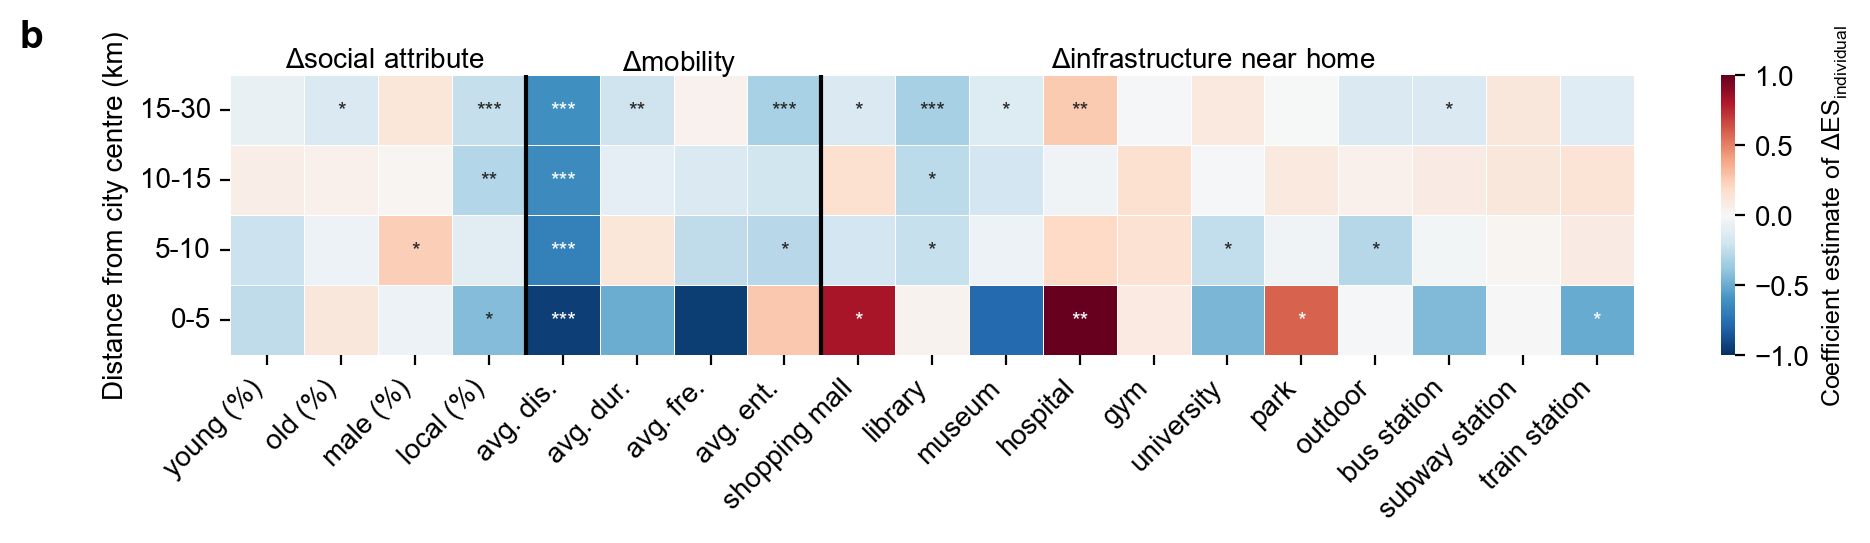

In [16]:
data = esi_results_df.iloc[:, 0::2]
p_value = esi_results_df.iloc[:, 1::2]

annotations = np.empty_like(p_value, dtype=object)
for i in range(p_value.shape[0]):
    for j in range(p_value.shape[1]):
        p = p_value.iloc[i, j]
        if p < 0.001:
            annotations[i, j] = '***'
        elif p < 0.01:
            annotations[i, j] = '**'
        elif p < 0.05:
            annotations[i, j] = '*'
        else:
            annotations[i, j] = ''

fig, ax = plt.subplots(figsize=(10, 3))
heatmap = sns.heatmap(data, linewidths=0.3, cmap="RdBu_r", fmt='s', 
                      vmax=1, vmin=-1,
                      annot=annotations, ax=ax)
ax.invert_yaxis()

cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel(r'$\mathregular{Coefficient \ estimate \ of \ \Delta ES_{individual}}$', fontsize=9)

font_size = 8
for text in ax.texts:
    text.set_fontsize(font_size)

ax.set_yticklabels(['0-5', '5-10', '10-15', '15-30'], rotation=0, fontsize=10)
ax.set_ylabel('Distance from city centre (km)', fontsize=10)
ax.set_xticklabels(['young (%)','old (%)','male (%)','local (%)','avg. dis.','avg. dur.', 'avg. fre.','avg. ent.',
                   'shopping mall','library','museum','hospital','gym','university','park','outdoor',
                   'bus station','subway station', 'train station'], 
                   rotation=45, ha='right', fontsize=10)

ax.text(-0.15, 1.2, 'b', transform=ax.transAxes, 
        fontsize=14, fontweight='bold', va='top', ha='left')
ax.text(0.11, 1.1, r'$\mathregular{ \Delta social \ attribute}$', transform=ax.transAxes, fontsize=10, va='top', ha='center')
ax.text(0.32, 1.1, r'$\mathregular{ \Delta mobility}$', transform=ax.transAxes, fontsize=10, va='top', ha='center')
ax.text(0.7, 1.1, r'$\mathregular{ \Delta infrastructure \ near \ home}$', transform=ax.transAxes, fontsize=10, va='top', ha='center')
ax.axvline(x=4, color='black', linestyle='-', linewidth=1.5)
ax.axvline(x=8, color='black', linestyle='-', linewidth=1.5)

plt.tight_layout()
# plt.savefig('fig3b.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [17]:
visit_ses_fre1903 = pd.read_csv(os.path.join(root, 'data', 'visit_ses_fre1903.csv'))
visit_ses_fre2403 = pd.read_csv(os.path.join(root, 'data', 'visit_ses_fre2403.csv'))
visit_poi_num2019 = pd.read_csv(os.path.join(root, 'data', 'visit_poi_num2019.csv'))
visit_poi_num2024 = pd.read_csv(os.path.join(root, 'data', 'visit_poi_num2024.csv'))
visit_grid_attribute = pd.read_csv(os.path.join(root, 'data', 'visit_grid_attribute.csv'))

def calculate_frequency_differences(df1903, df2403):
    merged = df2403.merge(df1903, on='visit_grid', suffixes=('_2403', '_1903'))
    freq_columns = ['ses1_fre', 'ses2_fre', 'ses3_fre', 'ses4_fre']
    for col in freq_columns:
        merged[f'{col}_diff'] = merged[f'{col}_2403'] - merged[f'{col}_1903']
    return merged

visit_ses_fre_diff = calculate_frequency_differences(visit_ses_fre1903, visit_ses_fre2403)
visit_ses_geo2403_six = pd.read_csv(os.path.join(root, 'data', 'visit_ses_geo2403_six.csv'))
visit_ses_geo1903_six = pd.read_csv(os.path.join(root, 'data', 'visit_ses_geo1903_six.csv'))
visit_home_distance_ses = pd.read_csv(os.path.join(root, 'data', 'visit_home_distance_ses.csv'))

visit_ses_geo_diff = visit_ses_geo2403_six.merge(
    visit_ses_geo1903_six, 
    on='visit_grid', 
    suffixes=('_2403', '_1903')
)
visit_ses_geo_diff['avg_ses_diff'] = visit_ses_geo_diff['avg_ses_2403'] - visit_ses_geo_diff['avg_ses_1903']

visit_poi_num_diff = (
    visit_poi_num2024.merge(visit_poi_num2019, on='fnid').iloc[:,1:12].to_numpy() 
    - visit_poi_num2024.merge(visit_poi_num2019, on='fnid').iloc[:,12:].to_numpy()
)
visit_poi_num_diff_df = pd.DataFrame(
    visit_poi_num_diff, 
    columns=visit_poi_num2024.columns[1:12]
)
visit_poi_num_diff_df['fnid'] = visit_poi_num2024.merge(visit_poi_num2019, on='fnid')['fnid']

visit_home_distance_ses_p = visit_home_distance_ses.pivot_table(
    index='visit_grid', 
    columns='ses2', 
    values='distance'
).reset_index()
visit_home_distance_ses_p.columns = ['visit_grid', 'ses_dis_1', 'ses_dis_2', 'ses_dis_3', 'ses_dis_4']

visit_grid_stat_change = (
    visit_grid_attribute.loc[:, ['visit_grid', 'isolation_diff']]
    .merge(
        visit_ses_geo1903_six.merge(
            visit_ses_geo2403_six, 
            on='visit_grid', 
            suffixes=('_1903', '_2403')
        )
    )
    .merge(visit_ses_geo_diff.loc[:, ['visit_grid', 'avg_ses_diff']])
    .merge(visit_ses_fre_diff.loc[:, ['visit_grid', 'ses1_fre_diff', 'ses2_fre_diff', 'ses3_fre_diff', 'ses4_fre_diff']])
    .merge(visit_home_distance_ses_p)
    .merge(visit_poi_num_diff_df.rename(columns={'fnid': 'visit_grid'}))
    .merge(grid_point_six_c.rename(columns={'fnid': 'visit_grid'}))
)

visit_grid_stat_change = visit_grid_stat_change.assign(
    ses2_3_fre_diff=visit_grid_stat_change['ses2_fre_diff'] + visit_grid_stat_change['ses3_fre_diff'],
    ses_dis_2_3=(visit_grid_stat_change['ses_dis_2'] + visit_grid_stat_change['ses_dis_3']) / 2
)

visit_grid_stat_change = visit_grid_stat_change.drop(
    columns=['ses2_fre_diff', 'ses3_fre_diff', 'ses_dis_2', 'ses_dis_3']
)

cols = visit_grid_stat_change.columns.tolist()
fre_diff_idx = cols.index('ses2_3_fre_diff')
dis_idx = cols.index('ses_dis_2_3')
cols.remove('ses2_3_fre_diff')
cols.remove('ses_dis_2_3')
cols.insert(6, 'ses2_3_fre_diff')
cols.insert(9, 'ses_dis_2_3')
visit_grid_stat_change = visit_grid_stat_change[cols]

In [18]:
target_var = 'isolation_diff'
explain_vars = ['avg_ses_diff', 
               'ses1_fre_diff', 'ses2_3_fre_diff', 'ses4_fre_diff',
               'ses_dis_1', 'ses_dis_2_3', 'ses_dis_4',
               'shopping_mall_count', 'library_count', 'museum_count', 
               'hospital_count', 'gym_count', 'university_count', 
               'park_count', 'outdoor_count', 'bus_station_count',
               'subway_station_count', 'train_station_count']

analysis_df = visit_grid_stat_change.copy()
distance_ranges = [(0, 5000), (5000, 10000), (10000, 15000), (15000, 30000)]
esp_results_df = pd.DataFrame()

for distance_min, distance_max in distance_ranges:
    print(f"\n===== Processing {distance_min}-{distance_max}m =====")
    subset_df = analysis_df[
        (analysis_df['distance_c'] >= distance_min) & 
        (analysis_df['distance_c'] < distance_max)
    ].copy()
    epsilon = 0.001 * subset_df[target_var].std()
    subset_df['isolation_increase'] = np.where(
        subset_df[target_var] > epsilon, 1,
        np.where(subset_df[target_var] < -epsilon, 0, np.nan)
    )
    subset_df = subset_df.dropna(subset=['isolation_increase'])
    X = subset_df[explain_vars]
    y = subset_df['isolation_increase']
    print("\n--- Checking for NaN/inf in features ---")
    print("NaN count:", X.isna().sum().sum())
    print("Inf count:", np.isinf(X.values).sum())
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())
    y = y[X.index] 
    print("\n--- VIF Analysis ---")
    try:
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        print(vif_data.sort_values("VIF", ascending=False))
    except Exception as e:
        print(f"VIF calculation failed: {str(e)}")
        continue
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    X_scaled = sm.add_constant(X_scaled)
    
    models = [
        {'name': 'Logit_BFGS', 'func': sm.Logit, 'kwargs': {'method': 'bfgs', 'maxiter': 1000}},
        {'name': 'L1_Regularized', 'func': sm.Logit, 'kwargs': {'method': 'l1', 'alpha': 0.1}}
    ]
    
    best_model = None
    best_score = -np.inf
    
    for config in models:
        try:
            print(f"\n--- Trying {config['name']} ---")
            
            if config['name'] == 'L1_Regularized':
                model = sm.Logit(y, X_scaled).fit_regularized(
                    alpha=config['kwargs']['alpha'],
                    disp=0
                )
            else:
                model = config['func'](y, X_scaled).fit(
                    disp=0,
                    **{k:v for k,v in config['kwargs'].items() if k != 'alpha'}
                )
            y_pred = model.predict(X_scaled)
            y_pred_class = (y_pred > 0.5).astype(int)
            score = accuracy_score(y, y_pred_class)
            print(f"Accuracy = {score:.3f}")
            
            print("\nModel Summary:")
            print(model.summary())
            
            if score > best_score:
                best_model = model
                best_score = score
                print("New best model")
        except Exception as e:
            print(f"Model failed: {str(e)}")
            continue
    
    if best_model is None:
        print(f"Skipped {distance_min}-{distance_max}m (all models failed)")
        continue
    
    coefficients = best_model.params.drop('const', errors='ignore')
    pvalues = best_model.pvalues.drop('const', errors='ignore')
    
    result_row = {'distance_range': f"{distance_min}-{distance_max}m"}
    for var in coefficients.index:
        result_row[f'{var}_coefficient'] = coefficients[var]
        result_row[f'{var}_pvalue'] = pvalues.get(var, np.nan)
    
    esp_results_df = pd.concat([esp_results_df, pd.DataFrame([result_row])], ignore_index=True)

esp_results_df = esp_results_df.set_index('distance_range')
print(esp_results_df)


===== Processing 0-5000m =====

--- Checking for NaN/inf in features ---
NaN count: 0
Inf count: 0

--- VIF Analysis ---
                Variable          VIF
5            ses_dis_2_3  2754.536009
4              ses_dis_1  2197.289200
6              ses_dis_4   234.889924
10        hospital_count    31.185159
11             gym_count    29.807011
15     bus_station_count    14.584626
14         outdoor_count     8.388544
7    shopping_mall_count     7.545796
1          ses1_fre_diff     6.484853
8          library_count     6.301950
2        ses2_3_fre_diff     6.271000
9           museum_count     6.181221
16  subway_station_count     4.295699
3          ses4_fre_diff     4.172797
13            park_count     3.987180
12      university_count     3.810729
17   train_station_count     3.702631
0           avg_ses_diff     2.262482

--- Trying Logit_BFGS ---
Accuracy = 0.959

Model Summary:
                           Logit Regression Results                           
Dep. Variable:   

In [19]:
coefficient_columns = [col for col in esp_results_df.columns if '_coefficient' in col]
pvalue_columns = [col for col in esp_results_df.columns if '_pvalue' in col]


results_table = pd.DataFrame()
variable_names = [col.replace('_coefficient', '').replace('_diff', '').replace('_change', '') 
                 for col in coefficient_columns]

model_info = {
    'Variable': ['Model Type', 'Pseudo R-squared', 'Log-Likelihood', 'LL-Null', 'Observations'],
    '0-5000m': ['Logit_BFGS', '0.5774', '-31.316', '-74.100', '246'],
    '5000-10000m': ['Logit_BFGS', '0.1584', '-396.76', '-471.45', '1215'],
    '10000-15000m': ['Logit_BFGS', '0.0693', '-1550.1', '-1665.4', '2868'],
    '15000-30000m': ['Logit_BFGS', '0.1388', '-5676.4', '-6591.1', '9924']
}

for i, var_name in enumerate(variable_names):
    row_data = {'Variable': var_name}
    for distance_range in esp_results_df.index:
        coef = esp_results_df.loc[distance_range, coefficient_columns[i]]
        pval = esp_results_df.loc[distance_range, pvalue_columns[i]]
        
        if pd.isna(pval):
            coef_str = f"{coef:.3f}"
        elif pval < 0.001:
            coef_str = f"{coef:.3f}***"
        elif pval < 0.01:
            coef_str = f"{coef:.3f}**"
        elif pval < 0.05:
            coef_str = f"{coef:.3f}*"
        else:
            coef_str = f"{coef:.3f}"
        
        row_data[distance_range] = coef_str
    
    results_table = pd.concat([results_table, pd.DataFrame([row_data])], ignore_index=True)

for info_key in model_info['Variable']:
    info_row = {'Variable': info_key}
    for distance_range in model_info.keys():
        if distance_range != 'Variable':
            info_row[distance_range] = model_info[distance_range][model_info['Variable'].index(info_key)]
    results_table = pd.concat([results_table, pd.DataFrame([info_row])], ignore_index=True)

final_order = []
variable_rows = []
info_rows = []

for idx, row in results_table.iterrows():
    if row['Variable'] in model_info['Variable']:
        info_rows.append(idx)
    else:
        variable_rows.append(idx)

final_order = variable_rows + info_rows
results_table = results_table.iloc[final_order].reset_index(drop=True)
# results_table.to_csv('.csv', index=False, encoding='utf-8-sig')

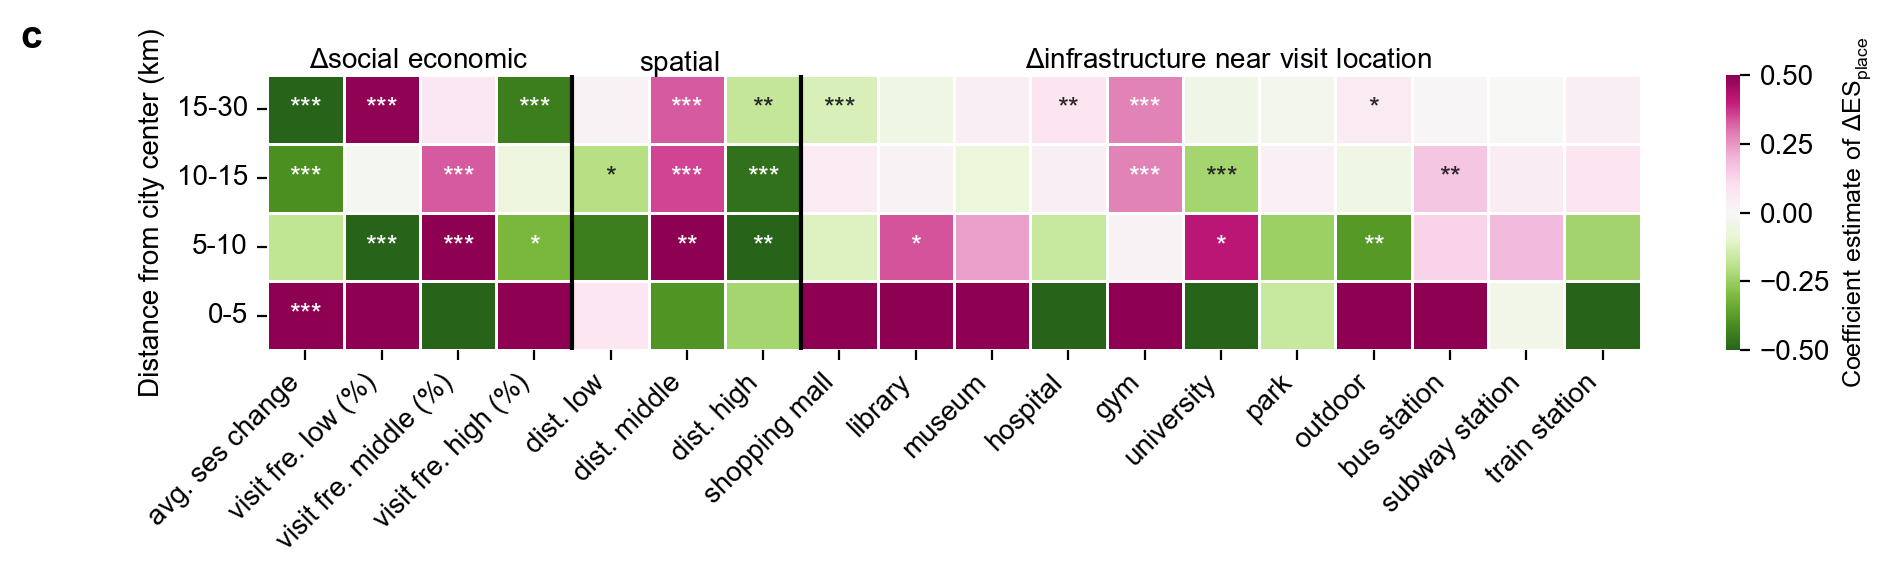

In [20]:
col_suffix = '_coefficient' if any('_coefficient' in col for col in esp_results_df.columns) else '_coef'
valid_vars = [col.replace(col_suffix, '') for col in esp_results_df.columns 
              if col_suffix in col and not esp_results_df[col].isna().all()]
distance_labels = ['0-5', '5-10', '10-15', '15-30']
coef_matrix = np.zeros((len(distance_labels), len(valid_vars)))
pval_matrix = np.full((len(distance_labels), len(valid_vars)), np.nan)

for i, distance_range in enumerate(esp_results_df.index):
    for j, var in enumerate(valid_vars):
        coef_matrix[i,j] = esp_results_df.loc[distance_range, f'{var}{col_suffix}']
        pval_matrix[i,j] = esp_results_df.loc[distance_range, f'{var}_pvalue']

significance = np.where(pval_matrix < 0.001, '***',
                       np.where(pval_matrix < 0.01, '**',
                               np.where(pval_matrix < 0.05, '*', '')))

group_positions = {
    'Socioeconomic': ['avg_ses_diff'],
    'Visit Frequency': ['ses1_fre_diff', 'ses2_3_fre_diff', 'ses4_fre_diff'],
    'Distance': ['ses_dis_1', 'ses_dis_2_3', 'ses_dis_4'],
    'Infrastructure': ['shopping_mall_count', 'library_count', 'museum_count',
                      'hospital_count', 'gym_count', 'university_count',
                      'park_count', 'outdoor_count', 'bus_station_count',
                      'subway_station_count', 'train_station_count']
}

plt.figure(figsize=(10, 3))
ax = sns.heatmap(
    coef_matrix,
    cmap="PiYG_r",
    center=0,
    annot=significance,
    fmt='s',
    linewidths=0.5,
    cbar_kws={'label': 'Coefficient Value'},
    vmin=-0.5,
    vmax=0.5,
    mask=np.isnan(coef_matrix)
)

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r'$\mathregular{Coefficient \ estimate \ of \ \Delta ES_{place}}$', fontsize=9)
ax.set_yticklabels(distance_labels, rotation=0, fontsize=10)
ax.set_ylabel('Distance from city center (km)', fontsize=10)

xticklabels = ['avg. ses change',
               'visit fre. low (%)', 'visit fre. middle (%)', 'visit fre. high (%)',
               'dist. low', 'dist. middle', 'dist. high',
               'shopping mall', 'library', 'museum', 'hospital', 'gym',
               'university', 'park', 'outdoor', 'bus station',
               'subway station', 'train station']
ax.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=10)

ax.text(-0.18, 1.2, 'c', transform=ax.transAxes, 
        fontsize=14, fontweight='bold', va='top', ha='left')
ax.text(0.11, 1.1, r'$\mathregular{ \Delta social \ economic}$', 
        transform=ax.transAxes, fontsize=10, va='top', ha='center')
ax.text(0.3, 1.1, r'$\mathregular{ spatial}$', 
        transform=ax.transAxes, fontsize=10, va='top', ha='center')
ax.text(0.7, 1.1, r'$\mathregular{ \Delta infrastructure \ near \ visit \ location}$', 
        transform=ax.transAxes, fontsize=10, va='top', ha='center')
ax.axvline(x=4, color='black', linestyle='-', linewidth=1.5)
ax.axvline(x=7, color='black', linestyle='-', linewidth=1.5)

ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# plt.savefig('fig3c.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [21]:
aoi_six = gpd.read_file(os.path.join(root, 'data', 'shp', '北京市AOI_SixRing_new.shp'))
aoi_six_type = pd.read_csv(os.path.join(root, 'data', 'aoi_six_beijing_new.csv'))
aoi_six_newtype = aoi_six.drop('newtype', axis=1).merge(aoi_six_type, on=['type', '一级类', '二级类']).loc[:,['uid','name','type', '一级类', '二级类','newtype','area','geometry']]
aoi_six_newtype.loc[(aoi_six_newtype['一级类']=='政府机构') & (aoi_six_newtype['二级类']=='社会团体') & (aoi_six_newtype['name'].str.contains('社区')), 'newtype'] = 'Resident'
aoi_six_newtype.loc[(aoi_six_newtype['name'].str.contains('北京市西郊雨洪调蓄工程')), 'newtype'] = 'Outdoors'
aoi_six_newtype.loc[(aoi_six_newtype['name'].str.contains('片区')), 'newtype'] = 'Nan'
aoi_six_newtype.loc[(aoi_six_newtype['name']=='北京经济技术开发区'), 'newtype'] = 'Nan'
aoi_six_newtype.loc[aoi_six_newtype['newtype']=='Food', 'newtype'] = 'Shopping'
aoi_six_newtype = aoi_six_newtype.loc[aoi_six_newtype['newtype']!='Nan']

In [22]:
grid250m = city_grid.loc[:,['fnid','geometry']]
aoi_six_grid = gpd.overlay(aoi_six_newtype, grid250m, how='intersection')
aoi_six_grid = aoi_six_grid.loc[:,['uid','name','newtype','fnid','geometry']]
aoi_six_grid['area'] = aoi_six_grid.to_crs(32650).geometry.area
aoi_six_grid_type = aoi_six_grid.loc[:,['fnid','newtype','area']].groupby(['fnid','newtype'],as_index=False).sum().groupby(['fnid'],as_index=False).max()

a = aoi_six_grid.loc[:, ['fnid', 'newtype', 'area']].groupby(['fnid', 'newtype'], as_index=False).sum()
a['area_prop'] = a.groupby('fnid')['area'].transform(lambda x: x / x.sum())
grid250m_type = grid250m.merge(a.loc[a['area_prop']>=0.9])
grid250m_type = grid250m_type.sjoin(sixth, predicate='intersects').drop(['index_right','Id'],axis=1)
# grid250m_type.to_file('grid250m_type.shp', driver='ESRI Shapefile', encoding='gbk')

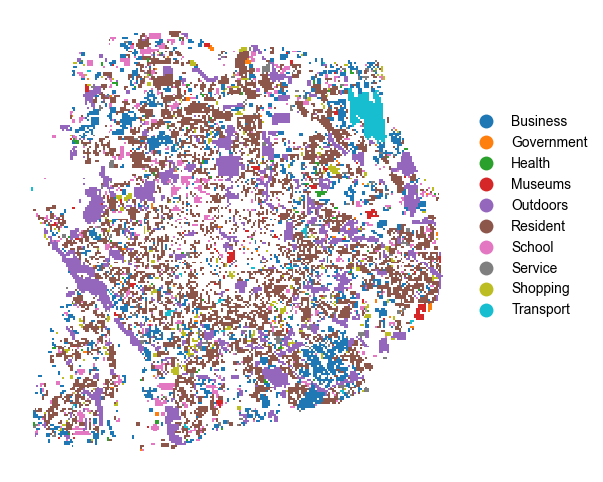

In [23]:
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
cmap = plt.get_cmap('tab10', len(grid250m_type['newtype'].unique()))
fig, ax = plt.subplots(figsize=(6, 6))
grid250m_type.plot(column='newtype', ax=ax, cmap=cmap, legend=True, legend_kwds={'bbox_to_anchor': (1.2, 0.8)})
# import contextily as ctx
# ctx.add_basemap(ax, url=ctx.providers.Esri.WorldTopoMap)
ax.set_axis_off()
sns.move_legend(ax, "upper right",  title=None, frameon=False, bbox_to_anchor=(1.3, 0.8))
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\pandas\core\arrays\categorical.py:596: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
C:\Users\DELL\AppData\Local\Temp\ipykernel_72216\789910816.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Low SES\n(p1 - p25)', 'Lower middle SES\n(p26 - p50)', 'Upper middle SES\n(p51 - p75)', 'High SES\n(p76 - p100)'],
D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\pandas\core\arrays\categorical.py:596: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
C:\Users\DELL\AppData\Local\Temp\ipykernel_72216\789910816.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Low SES\n(p1 - p25)', 'Lower middle SES\n(p26 - p

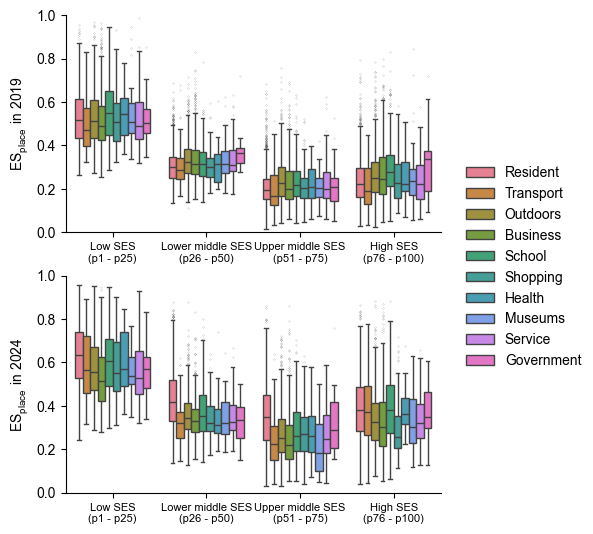

In [24]:
visit_ses_geo1903_six = pd.read_csv(os.path.join(root, 'data', 'visit_ses_geo1903_six.csv'))
visit_ses_geo2403_six = pd.read_csv(os.path.join(root, 'data', 'visit_ses_geo2403_six.csv'))
visit_iso1903 = pd.read_csv(os.path.join(root, 'data', 'visit_iso1903.csv'))
visit_iso2403 = pd.read_csv(os.path.join(root, 'data', 'visit_iso2403.csv'))
visit_grid_attribute = visit_iso1903.merge(visit_iso2403, on='visit_grid',  suffixes=('_1903','_2403')).merge(grid250m_type.loc[:,['fnid','newtype']].rename(columns={'fnid':'visit_grid'}))
a = visit_grid_attribute.merge(visit_ses_geo1903_six.merge(visit_ses_geo2403_six, on='visit_grid', suffixes=('_1903','_2403')), on='visit_grid')
a1903 = a.loc[:, ['visit_grid', 'isolation_1903', 'avg_ses_1903', 'newtype']]
a1903.columns = ['visit_grid', 'isolation', 'ses', 'newtype']
a2403 = a.loc[:, ['visit_grid', 'isolation_2403', 'avg_ses_2403', 'newtype']]
a2403.columns = ['visit_grid', 'isolation', 'ses', 'newtype']
a1903['year'] = 2019
a2403['year'] = 2024
a_new = pd.concat([a1903, a2403], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(6, 6.2))

a1903['ses_group'] = pd.qcut(a1903['ses'], q=4, labels=['low ses', 'lower middle ses', 'upper middle ses', 'high ses'])
sns.boxplot(data=a1903, x='ses_group', y='isolation', hue='newtype', palette='husl', fliersize=0.1, ax=axes[0])
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('')
axes[0].set_ylabel(r'$\mathregular{ES_{place} \ in \ 2019}$')
axes[0].set_xticklabels(['Low SES\n(p1 - p25)', 'Lower middle SES\n(p26 - p50)', 'Upper middle SES\n(p51 - p75)', 'High SES\n(p76 - p100)'],
                        fontsize=8, rotation=0, ha='center')

a2403['ses_group'] = pd.qcut(a2403['ses'], q=4, labels=['low ses', 'lower middle ses', 'upper middle ses', 'high ses'])
sns.boxplot(data=a2403, x='ses_group', y='isolation', hue='newtype', palette='husl', fliersize=0.1, ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('')
axes[1].set_xticklabels(['Low SES\n(p1 - p25)', 'Lower middle SES\n(p26 - p50)', 'Upper middle SES\n(p51 - p75)', 'High SES\n(p76 - p100)'],
                        fontsize=8, rotation=0, ha='center')
axes[1].set_ylabel(r'$\mathregular{ES_{place} \ in \ 2024}$')
axes[0].get_legend().remove()
axes[1].get_legend().remove()

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='center right', ncol=1, title='', frameon=False)

plt.subplots_adjust(right=0.75)

sns.despine()
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()